In [6]:
import pandas
import io
import uuid
import datetime
import pathlib
from fabric import Connection
import os
cur_dir=os.getcwd() # save current directory to save the generated CSV files
print(cur_dir)




C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python


In [7]:
location = "nancy"
node = "grouille-2"
c1 = Connection(host='ccaulier@access.grid5000.fr')
# print(c1.run("hostname"))
c2 = Connection(host='ccaulier@{}'.format(location), gateway=c1)
# print(c2.run("hostname"))
c = Connection(host='ccaulier@{}'.format(node), gateway=c2)

In [8]:
import time
def runExperiment(source_parallelism,main_parallelism, aggregator_parallelism ,notebook_dir, dataFileDirectory, remote_output_file, local_output_file, remote_throughput_file, local_throughput_file):
    c.run("./flink-1.18.1/bin/start-cluster.sh")
    # c.run("bash runPrometheusAndFlink.sh {} {}".format(main_parallelism, dataFileDirectory))
    # print("python fakePrometheus.py > throughput.dat &")

    # c.run("bash runPrometheusBusynessPerVertexAndFlink.sh {} {} {}".format(main_parallelism, dataFileDirectory, "javaSource"))
    # print("python fakePrometheusBusynessPerVertex.py > throughput.dat &")

    c.run("bash runPrometheusAndFlink.sh {} {} {} {} {}".format(source_parallelism,main_parallelism, aggregator_parallelism, dataFileDirectory, "javaSource"))
    print("python fakePrometheus.py > throughput.dat &")

    print("running flink jobs")
    time.sleep(5)
    c.get(remote_output_file, "%s/%s" % (notebook_dir, local_output_file))
    c.get(remote_throughput_file, "%s/%s" % (notebook_dir, local_throughput_file))
    c.run("flink-1.18.1/bin/stop-cluster.sh")
    

In [9]:
experimentName = "400000_75_javaSource_5_5_1"
experimentDirectory = "%s/experiments/experiment_%s/" % (cur_dir,experimentName)
dataDirectory = "param_400000_75.csv"
# pathlib.Path(experimentDirectory).mkdir(exist_ok=True, parents=True)
n_experiments = 5
start_experirment = 4
source_parallelism = 5
main_parallelism = 5
aggregator_parallelism = 1


In [10]:
for i in range(start_experirment,n_experiments):
    print("Experiment %s" % i)
    currentExperimentDirectory = "%s%s" % ( experimentDirectory, i )
    pathlib.Path(currentExperimentDirectory).mkdir(exist_ok=True, parents=True)

    runExperiment(source_parallelism,main_parallelism, aggregator_parallelism, currentExperimentDirectory, dataDirectory, "output.dat", "output.dat", "throughput.dat", "throughput.dat")

Experiment 4
Starting cluster.
Starting standalonesession daemon on host grouille-2.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-2.nancy.grid5000.fr.
[INFO] 1 instance(s) of taskexecutor are already running on grouille-2.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-2.nancy.grid5000.fr.
[INFO] 2 instance(s) of taskexecutor are already running on grouille-2.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-2.nancy.grid5000.fr.
[INFO] 3 instance(s) of taskexecutor are already running on grouille-2.nancy.grid5000.fr.
Starting taskexecutor daemon on host grouille-2.nancy.grid5000.fr.
Current working directory: /home/ccaulier
Benchmark is loaded from /home/ccaulier/flinkImplemProject.jar
Source parallelism: 5
Main parallelism: 5
Aggregator parallelism: 1
Directory name: param_400000_75.csv
MeanHybrid
MeanAggregateAware
MeanRoundRobin
MeanCAMRoundRobin
MeanHash
MeanHashRoundRobin
MeanTopKCAMRoundRobin
MeanTopKHashRoundRobin
MeanPKG
MeanDC

In [12]:
import pandas as pd
import re

def parse_data_csvfile(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            csv_source = metric_data[5].split("_")
            # print(csv_source)
            csv_source[5] = csv_source[5].replace(".csv", "")
            if(csv_source[5] == "1.0E-15"):
                csv_source[5] = "0.0"
            # print(csv_source)
            csv_source.remove("distribution")
            for val in csv_source:
                metric_data.append(val)

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df


def parse_data_javaSource(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    metric_pattern = re.compile(r'^metric:(.+)$')
    runtime_pattern = re.compile(r'Job Runtime: (\d+) ms')

    data = []
    current_runtime = None  # To store runtime for next metric entry

    for line in lines:
        runtime_match = runtime_pattern.search(line)
        if runtime_match:
            current_runtime = int(runtime_match.group(1))

        metric_match = metric_pattern.match(line)
        if metric_match and current_runtime is not None:
            metric_data = metric_match.group(1).split(',')
            metric_data.insert(5,"javaSource")
            metric_data[8], metric_data[9] = metric_data[9], metric_data[8]


            if(metric_data[10] == "1.0E-15"):
                metric_data[10] = "0.0"

            metric_data.append(current_runtime)  # Append the runtime to metric data
            data.append(metric_data)
            print(metric_data)
            current_runtime = None  # Reset runtime after adding to data

    # Define DataFrame column names
    column_names = ['Operator', 'Duration', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew', 'Runtime (ms)']
    # Create DataFrame
    df = pd.DataFrame(data, columns=column_names)
    return df

def save_dataframe_to_csv(df, output_path):
    df.to_csv(output_path, index=False)


# n_experiments = 3
main_df =pd.DataFrame()
for i in range(n_experiments):
    
    experimentFile = "%s%s/output.dat" % ( experimentDirectory, i )
    print(experimentFile)
    df= parse_data_javaSource(experimentFile)
    save_dataframe_to_csv(df,"%s%s/output.csv" % ( experimentDirectory, i ))
    main_df = pd.concat([main_df, df], ignore_index=True)

# main_df.to_csv(main_df)

C:\Users\Camil\OneDrive\Documents\masters\memoire\flinkImplemProject\src\main\python/experiments/experiment_400000_75_javaSource_5_5_1/0/output.dat
['MeanHybrid', '26089', '2', '2', '0', 'javaSource', 'zipf', '400000', '1', '75', '0.0', 23044]
['MeanHybrid', '21260', '2', '2', '0', 'javaSource', 'zipf', '400000', '1', '75', '0.7', 19644]
['MeanHybrid', '27244', '2', '2', '0', 'javaSource', 'zipf', '400000', '1', '75', '1.4', 25848]
['MeanHybrid', '31254', '2', '2', '0', 'javaSource', 'zipf', '400000', '1', '75', '2.1', 29467]
['MeanHybrid', '21252', '2', '2', '0', 'javaSource', 'zipf', '400000', '2', '75', '0.0', 18823]
['MeanHybrid', '19212', '2', '2', '0', 'javaSource', 'zipf', '400000', '2', '75', '0.7', 18537]
['MeanHybrid', '27184', '2', '2', '0', 'javaSource', 'zipf', '400000', '2', '75', '1.4', 25261]
['MeanHybrid', '31178', '2', '2', '0', 'javaSource', 'zipf', '400000', '2', '75', '2.1', 29413]
['MeanHybrid', '23213', '2', '2', '0', 'javaSource', 'zipf', '400000', '3', '75', '0

In [13]:
main_df

,Operator,Duration,MainParallelism,HybridParallelism,Choices,CSVSource,distributionType,eventPerWindow,keySize,amountOfWindows,skew,Runtime (ms)
0,MeanHybrid,26089,2,2,0,javaSource,zipf,400000,1,75,0.0,23044
1,MeanHybrid,21260,2,2,0,javaSource,zipf,400000,1,75,0.7,19644
2,MeanHybrid,27244,2,2,0,javaSource,zipf,400000,1,75,1.4,25848
3,MeanHybrid,31254,2,2,0,javaSource,zipf,400000,1,75,2.1,29467
4,MeanHybrid,21252,2,2,0,javaSource,zipf,400000,2,75,0.0,18823
...,...,...,...,...,...,...,...,...,...,...,...,...
655,MeanWChoices,17183,5,0,0,javaSource,zipf,400000,2,75,2.1,16426
656,MeanWChoices,17177,5,0,0,javaSource,zipf,400000,3,75,0.0,16539
657,MeanWChoices,19168,5,0,0,javaSource,zipf,400000,3,75,0.7,17322
658,MeanWChoices,19173,5,0,0,javaSource,zipf,400000,3,75,1.4,18242


In [14]:
import matplotlib.pyplot as plt

# Group data and calculate mean and range of runtime
main_df.drop(columns=['Duration'])
grouped = main_df.groupby(['Operator', 'MainParallelism', 'HybridParallelism', 'Choices', 'CSVSource','distributionType','eventPerWindow','keySize','amountOfWindows','skew'])
runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'}).reset_index()
# runtime_stats = grouped['Runtime (ms)'].agg(['mean', lambda x: x.max() - x.min()]).rename(columns={'<lambda_0>': 'range'})
runtime_stats['keySize']

0      1
1      1
2      1
3      1
4      2
      ..
127    2
128    3
129    3
130    3
131    3
Name: keySize, Length: 132, dtype: object

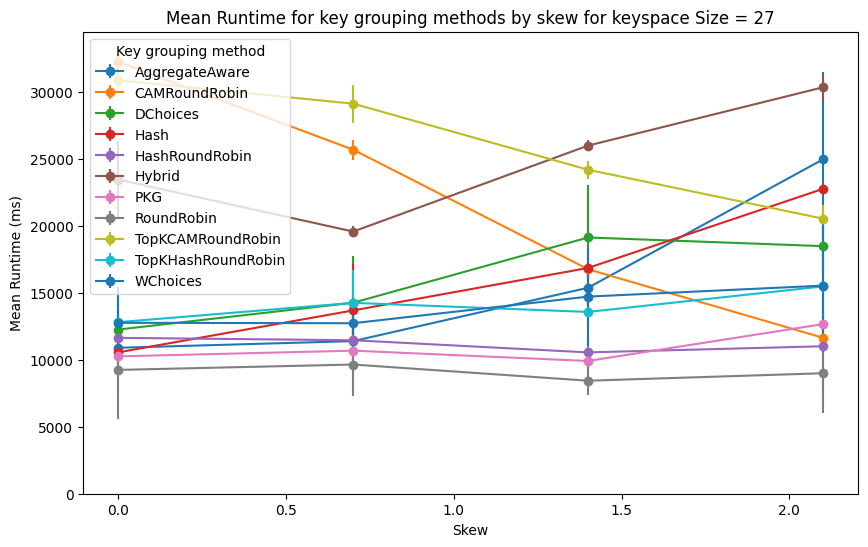

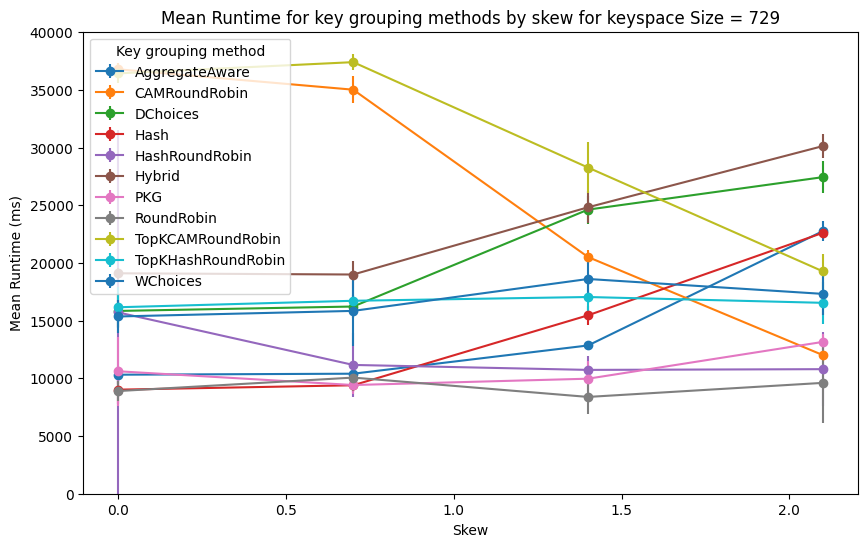

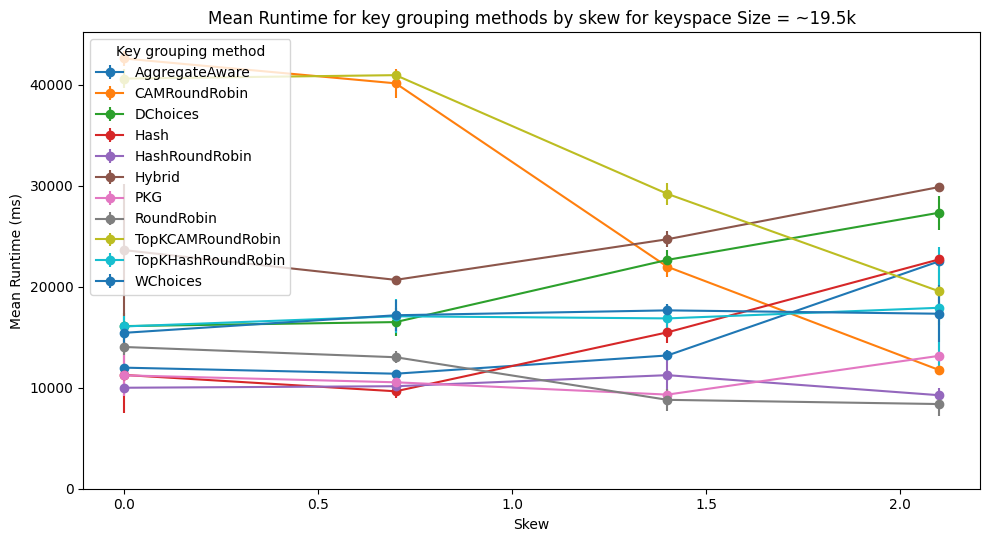

In [19]:

runtime_stats['skew'] = runtime_stats['skew'].astype(float)
listOfKeySizes = [27**1, 27**2, "~19.5k"]
sorted_runtime_stats = runtime_stats.sort_values(by='skew')
for i in range(1,3+1):
    keysize_2_data = runtime_stats[runtime_stats['keySize'] == str(i)].sort_values(by='skew')


    # Set up the plotting area
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data for each operator
    for name, group in keysize_2_data.groupby('Operator'):
        if not group.empty:
            # print(group['skew'])
            ax.errorbar(group['skew'], group['mean'], yerr=group['range']/2, fmt='-o', label=f'{name[4:]}')
        else:
            print(f"No data for Operator {name} with keySize == {i}")

    # Label the axes and the plot
    ax.set_xlabel('Skew')
    ax.set_ylabel('Mean Runtime (ms)')
    ax.set_title('Mean Runtime for key grouping methods by skew for keyspace Size = {}'.format(listOfKeySizes[i-1]))
    ax.legend(title='Key grouping method', loc='upper left')
     # Set the y-axis to start at 0
    ax.set_ylim(bottom=0)

    # Show the plot
    # plt.show()
    plt.savefig(experimentDirectory+"plot{}.png".format(i))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

